In [37]:
import numpy as np
import pandas as pd
np.random.seed(0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/preClasificacion.csv')

In [3]:
data

,Unnamed: 0,idGenero,edad_grupos,idEstadoCivil,Analisis,Medicion1_PA_Sistolica,Medicion2_PA_Diastolica,Medicion3_Frecuencia_cardiaca,Medicion4_Frec_Respiratoria,Medicion5_Temperatura,...,Medicion8_IMC,motivoPaciente,enfermedadActual,Zona2_Cabeza_Cuello,Zona3_Cardio_Pulmonar,codigoDiagnostico,Concepto,id,original,dataset
0,0,1,1-67,9,HIPERTENCION,138,82,64,19,36.3,...,28.73,CONTROL,PACIENTE DE 60 AÑOS DE EDAD CON DIAGNOSTICOS ...,Sin alteraciones.,RSCS RIMTICOS SIN SOPLOS RSRS MURMULLO EVSICUL...,I10X,PACIENTE DE 60 AÑOS DE EDAD CON DIAGNOSTICOS H...,1,True,train
1,1,2,78-84,1,HIPERTENCION,187,64,73,17,36.2,...,30.42,""" TENEMOS EL CONTROL """,PACIENTE DE 76 AÑOS CON DIAGNOSTICO: 1. HIP...,Sin alteraciones.,RSRS SIN AGREGADOS RSCS RITMICOS SIN SOPLOS,I10X,PACIENTE EN PROGRAMA CRONICO; CURSA CON HTA EN...,2,True,train
2,8,2,1-67,3,HIPERTENCION,118,75,90,19,36.2,...,26.02,CONTROL CRÓNICOS CAPITAL SALUD NATURAL LA CAP...,PACIENTE FEMENINA DE 54 AÑOS CON DIAGNÓSTICOS ...,SIN CIANOSIS,RUIDOS CARDIOVASCULAR RUIDOS RESPIRATORIOS CO...,I10X,PACIENTE FEMENINA CON DIAGNÓSTICOS ANOTADOS S...,9,True,train
3,9,2,>84,1,HIPERTENCION,158,59,58,15,36.0,...,24.89,CONTROL PROGRAMA CRONICOS,PACIENTE DE 84 AÑOS CON DIAGNOSTICOS DE: 1. E...,NO INGURGITACION YUGULAR.,RSCS RITMICOS SIN SOPLOS. RSRS MV CONSERVADOS ...,I10X,PACIENTE ADULTA MAYOR CON DIAGNOSTICOS ANOTAD...,10,True,train
4,11,2,1-67,9,HIPERTENCION,112,76,95,20,36.6,...,34.19,CONTROL,PACIENTE DE 42 AÑOS DE EDAD CON DIAGNOSTICO DE...,Sin alteraciones.,RSCS RITMICOS SIN SOPLOS RSRS MURMULLO EVSICUL...,I10X,PACIENTE DE 42 AÑOS DE EDAD CON DIAGNOSTICO DE...,12,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96901,98057,1,1-67,1,EPILEPSIA,115,70,65,20,36.0,...,21.10,REFORMULACIÓN NEUROLOGIA,PACIENTE DE 32 AÑOS CON DIAGNÓSTICOS DE: 1. ...,I,I,G402,PACIENTE MASCULINO CON CUADRO DE EPILEPSIA EN ...,98058,True,test
96902,82775,2,78-84,3,EPILEPSIA,130,80,85,18,37.0,...,24.00,CITA DE CONTROL - REFORMULACION NEUROLOGIA,PACIENTE FEMENINA DE 79 AÑOS CON DIAGNOTICOS D...,MUCOSA ORAL HUMEDA ESCLERAS ANICTERICAS CUELLO...,RUIDOS CARDIACOS RITMICOS SIN SOPLOS RUIDOS RE...,G401,PACIENTE DE 79 AÑOS CON DIAGNOSTICO DE EPILEPS...,82776,True,test
96903,59797,1,1-67,1,EPILEPSIA,100,60,80,22,36.0,...,27.70,REFORMULACION,PACIENTE MASCULINO DE 20 AÑOS CON DX: 1. EPILE...,I,I,G402,PACIENTE JOVEN CON HISTORIA DE EPILEPSIA FOCAL...,59798,True,test
96904,62974,1,78-84,9,EPILEPSIA,110,60,83,22,36.0,...,27.28,REFORMULACION,PACIENTE MASCULINO DE 77 AÑOS DE EDAD CON DIAG...,I,I,G409,PACIENTE MASCULINO DE 77 AÑOS DE EDAD CON ANT...,62975,True,test


In [4]:
data.columns

Index(['Unnamed: 0', 'idGenero', 'edad_grupos', 'idEstadoCivil', 'Analisis',
       'Medicion1_PA_Sistolica', 'Medicion2_PA_Diastolica',
       'Medicion3_Frecuencia_cardiaca', 'Medicion4_Frec_Respiratoria',
       'Medicion5_Temperatura', 'Medicion6_Peso', 'Medicion7_Talla',
       'Medicion8_IMC', 'motivoPaciente', 'enfermedadActual',
       'Zona2_Cabeza_Cuello', 'Zona3_Cardio_Pulmonar', 'codigoDiagnostico',
       'Concepto', 'id', 'original', 'dataset'],
      dtype='object')

In [5]:
uniqAges = data.edad_grupos.unique()
uniqAges = {x:i for i,x in enumerate(uniqAges)}

target = data.Analisis.unique()
target = {x:i for i,x in enumerate(target)}


print(uniqAges)
print(target)


{'1-67': 0, '78-84': 1, '>84': 2, '68-77': 3}
{'HIPERTENCION': 0, 'APNEA': 1, 'PULMONAR': 2, 'DIABETES': 3, 'EPILEPSIA': 4}


In [6]:
data['edad_grupos'] = list(map(lambda x:uniqAges[x], data['edad_grupos']))
data['Analisis'] = list(map(lambda x:target[x], data['Analisis']))

In [19]:
xfeatures = list(data.columns[1:-9])
xfeatures.remove('Analisis')
print(xfeatures)

['idGenero', 'edad_grupos', 'idEstadoCivil', 'Medicion1_PA_Sistolica', 'Medicion2_PA_Diastolica', 'Medicion3_Frecuencia_cardiaca', 'Medicion4_Frec_Respiratoria', 'Medicion5_Temperatura', 'Medicion6_Peso', 'Medicion7_Talla', 'Medicion8_IMC']


In [20]:
train = data[data.dataset=='train']
test = data[data.dataset=='test']

In [21]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [22]:
#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(train[xfeatures], train.Analisis)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=0.999, test=0.649), f1_score=(train=0.999, test=0.584), precision=(train=0.999, test=0.585), recall=(train=0.999, test=0.649), total=  13.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=0.999, test=0.624), f1_score=(train=0.999, test=0.562), precision=(train=0.999, test=0.561), recall=(train=0.999, test=0.624), total=  14.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.4s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=0.999, test=0.649), f1_scor

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weigh...
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]},
             pre_dispatch='2*n_jobs', refit='f1_score', return_train_sc

In [23]:
clf = grid_search

In [24]:
cm = confusion_matrix(test.Analisis, clf.predict(test[xfeatures])).transpose()


In [25]:
cm

array([[ 1060,   184,   237,   147,    11],
       [  413,  2092,   484,   233,    63],
       [ 2588,  1372, 13459,   797,   138],
       [   53,    45,    38,   213,     2],
       [   24,    42,    39,    13,   477]])

In [26]:
{'PULMONAR': 0, 'HIPERTENCION': 1, 'DIABETES': 2, 'APNEA': 3, 'EPILEPSIA': 4}


{'PULMONAR': 0, 'HIPERTENCION': 1, 'DIABETES': 2, 'APNEA': 3, 'EPILEPSIA': 4}

In [27]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [28]:
newMatr = []
for i in range(len(cm)):
    prec = cm[i][i]/(sum(cm[i,:]))
    rec = cm[i][i]/(sum(cm[:,i]))
    newMatr.append([prec,rec,fMeasure(prec,rec),sum(cm[:,i])])

In [29]:
np.set_printoptions(suppress=True)
print('    Precision        Recall         F-score      Cover')
print(np.array(newMatr))
np.set_printoptions(suppress=False)

    Precision        Recall         F-score      Cover
[[    0.64673581     0.2561624      0.36697248  4138.        ]
 [    0.63683409     0.5601071      0.5960114   3735.        ]
 [    0.73330064     0.9440275      0.825427   14257.        ]
 [    0.60683761     0.15181753     0.24287343  1403.        ]
 [    0.80168067     0.69030391     0.74183515   691.        ]]


In [33]:
print('F1 promedio = {:.4f}%'.format(np.average(np.array(newMatr)[:,2])*100))

F1 promedio = 55.4624%


In [35]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = xfeatures.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]

Text(0.5, 1.0, 'Importancia de los features')

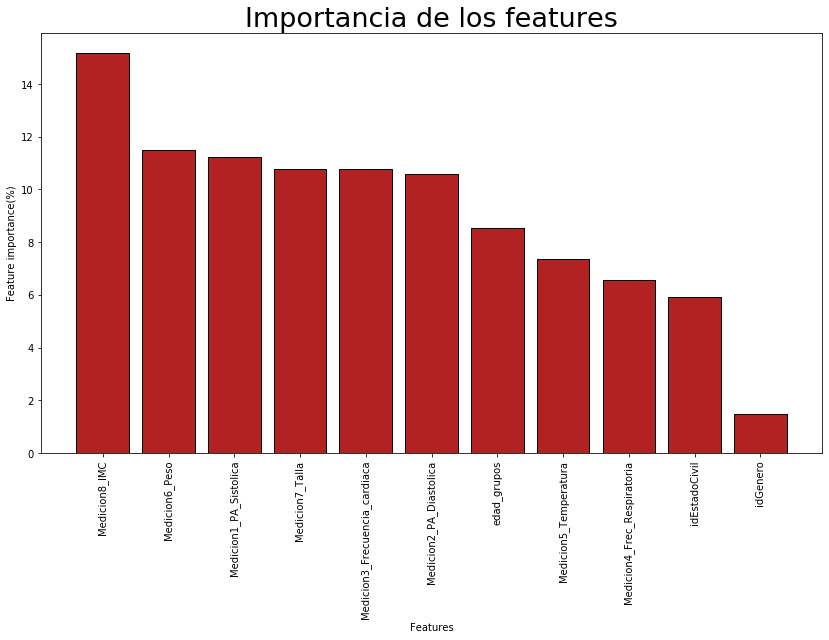

In [42]:
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Importancia de los features",fontsize = 27)
# plt.savefig("../results/binFeatImportance.pdf")